In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from matplotlib import pyplot
import scipy.stats as st
import scipy.signal
import pandas
import openpyxl

Comment: calculation times in this notebook are inflated since the PC was in use for another process

#### First peak ever

In [2]:
time = np.fromfile("time.npy")
intensity = np.fromfile("intensity.npy")

with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 50, 50)
    noise = pm.LogNormal("noise", np.log(50), 1)
    mean = pm.Normal("mean", np.mean(time[[0, -1]]), np.ptp(time) / 2)
    std = pm.HalfNormal("std", np.ptp(time) / 3)
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity) * 0.9)

    # posterior with x = time = 0
    pm.Deterministic("height", baseline + area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + area * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time - mean) / std)**2))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)

In [3]:
with pmodel:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())

Sampling: [L, area, baseline, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, area]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


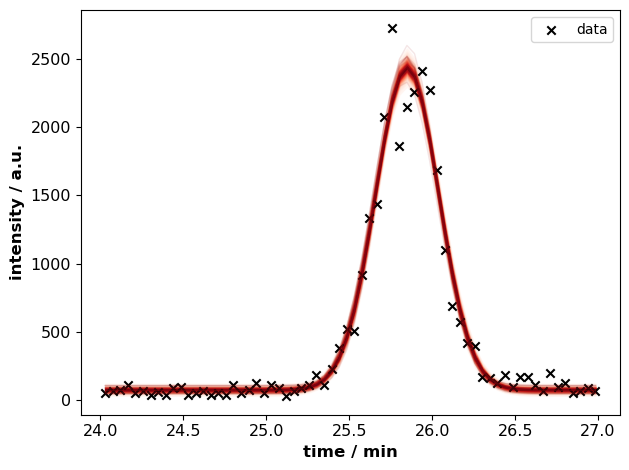

In [4]:
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time,
    samples=idata.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time, intensity, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
pyplot.legend()
pyplot.xticks(size=11.5)
pyplot.yticks(size=11.5)
pyplot.tight_layout()
pyplot.show()

#### Normal distribution with parametrized priors and linear baseline (plus exchanged area with height in posterior)

In [ ]:
# guess for priors
noise_range = int(np.round(1/3 * len(intensity), decimals=0))
noise_tuple = intensity_tuple[:noise_range]
# sort noise_tuple by time, then use the first and last data points for estimating starting values for the priors of noise width and the slope and intercept of baseline
noise_tuple.sort(key=lambda x: x[0])
slope_guess = (np.mean([noise_tuple[n][1] for n in range(len(noise_tuple)-5, len(noise_tuple))])-np.mean([noise_tuple[n][1] for n in range(5)]))/(time_np[-1] - time_np[0])
intercept_guess = np.mean([noise_tuple[n][1] for n in range(5)])
noise_width_guess = np.max([noise_tuple[n][1] for n in range(len(noise_tuple))]) - np.min([noise_tuple[n][1] for n in range(len(noise_tuple))])

with pm.Model() as pmodel:
    # priors plus error handling in case of mathematically impermissible values
    if intercept_guess == 0:
        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, 20)
    else:
        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, intercept_guess / 2)
    print(np.abs(slope_guess*2))
    baseline_slope = pm.Normal("baseline_slope", slope_guess, np.abs(slope_guess*2)+1)
    baseline = pm.Deterministic("baseline", baseline_intercept + baseline_slope * time)
    # since log(0) leads to -inf, this case is handled by setting noise_width_guess to 10
    if noise_width_guess > 0:
        noise = pm.LogNormal("noise", np.log(noise_width_guess), 1)
    elif noise_width_guess == 0:
        noise = pm.LogNormal("noise", np.log(10), 1)
    mean = pm.Normal("mean", np.mean(time[[0, -1]]), np.ptp(time) / 2)
    std = pm.HalfNormal("std", np.ptp(time) / 3)
    height = pm.HalfNormal("height", 0.95 * np.max(intensity))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    sn = pm.Deterministic("sn", height/noise)
    # posterior
    y = baseline + height * pt.exp(-0.5 * ((time - mean) / std)**2)
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)

#### Double peaks

In [8]:
time = np.fromfile("double_time.npy")
intensity = np.fromfile("double_intensity.npy")

with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 500, 50)
    noise = pm.LogNormal("noise", np.log(100), 1)
    std = pm.HalfNormal("std", np.ptp(time) / 3)
    std2 = pm.HalfNormal("std2", np.ptp(time) / 3)
    height = pm.HalfNormal("height", 0.95 * np.max(intensity))
    height2 = pm.HalfNormal("height2", 0.95 * np.max(intensity))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    area2 = pm.Deterministic("area2", height2/(1 / (std2 * np.sqrt(2 * np.pi))))
    mean = pm.Normal("mean", mu=[time[0] + np.ptp(time) * 1/4, time[0] + np.ptp(time) * 3/4], sigma=1, transform=pm.distributions.transforms.univariate_ordered)
    # posterior
    y = baseline + height * pt.exp(-0.5 * ((time - mean[0]) / std)**2) + height2 * pt.exp(-0.5 * ((time - mean[1]) / std2)**2)
    y = pm.Deterministic("y", y)

    # likelihood
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)

In [9]:
with pmodel:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=2000, tune=2000))

Sampling: [L, baseline, height, height2, mean, noise, std, std2]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, std, std2, height, height2, mean]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 83 seconds.


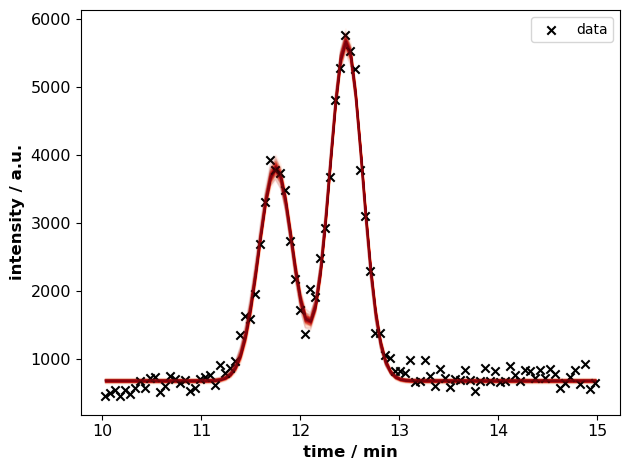

In [10]:
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time,
    samples=idata.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time, intensity, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
pyplot.legend()
pyplot.xticks(size=11.5)
pyplot.yticks(size=11.5)
pyplot.tight_layout()
pyplot.show()

In [22]:
az.summary(idata).loc[["height","height2","area","area2","mean[0]","mean[1]"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
height,3145.998,84.454,2981.575,3299.760,1.072,0.758,6206.0,6092.0,1.0
height2,5000.162,82.844,4840.824,5151.121,0.940,0.665,7774.0,5935.0,1.0
area,1355.563,40.175,1281.607,1432.258,0.404,0.286,9890.0,7201.0,1.0
area2,2086.243,38.372,2012.742,2156.619,0.438,0.310,7673.0,6498.0,1.0
mean[0],11.751,0.005,11.740,11.760,0.000,0.000,5565.0,5112.0,1.0
mean[1],12.462,0.003,12.456,12.468,0.000,0.000,8085.0,6413.0,1.0


#### Skew normal distribution

In [23]:
time_np = np.fromfile("A1_t1_1_Part2_His110_M0_m0_time.npy")
intensity_np = np.fromfile("A1_t1_1_Part2_His110_M0_m0_intensity.npy")

with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    height = pm.HalfNormal("height", 0.95 * np.max(intensity_np))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + height * (2 * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2))))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [24]:
with pmodel:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(2000, tune = 2000))

Sampling: [L, alpha, baseline, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, alpha, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.


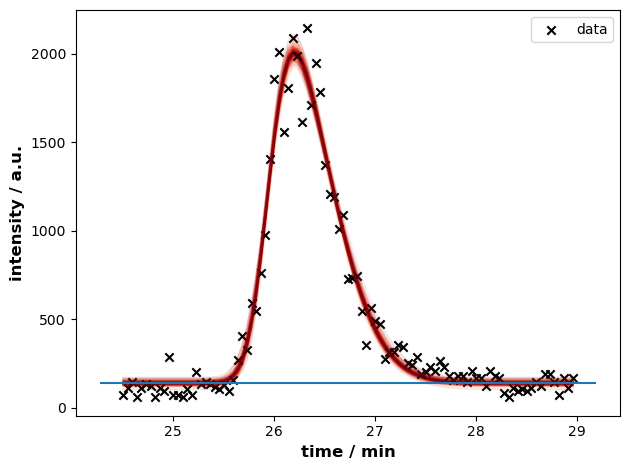

In [25]:
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
# plot baseline
x = np.array(ax.get_xlim())
y_baseline = az.summary(idata).loc["baseline","mean"]
y = [y_baseline] * len(x)
pyplot.plot(x, y)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

In [55]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,141.444,13.436,115.517,166.317,0.173,0.123,6022.0,5049.0,1.0
mean,25.951,0.013,25.928,25.977,0.000,0.000,2950.0,3714.0,1.0
noise,104.703,7.860,90.671,119.740,0.101,0.072,6058.0,4880.0,1.0
std,0.523,0.022,0.482,0.563,0.000,0.000,2731.0,3251.0,1.0
alpha,2.964,0.392,2.255,3.724,0.008,0.005,2647.0,3550.0,1.0
...,...,...,...,...,...,...,...,...,...
y[94],141.446,13.435,115.518,166.318,0.173,0.123,6022.0,5049.0,1.0
y[95],141.445,13.435,115.518,166.318,0.173,0.123,6022.0,5049.0,1.0
y[96],141.445,13.435,115.517,166.318,0.173,0.123,6022.0,5049.0,1.0
y[97],141.445,13.436,115.517,166.317,0.173,0.123,6022.0,5049.0,1.0


Question: Is there an easy way to calculate the mode of a skew normal distribution? (To determine the height. Otherwise: find x axis intercepts of first derivative (local maximum))